# Import libraries

In [114]:
import numpy as np
import networkx as nx
import pandas as pd
from thefuzz import process
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from patsy import dmatrix

# Create the network

In [115]:
data = pd.read_csv('network_data.csv', index_col = 0)
df = data.groupby(['source', 'target']).size().reset_index(name='weight')
df = data.merge(df, on=['source', 'target'], how='left')

In [116]:
G = nx.from_pandas_edgelist(df = df,
                            source = 'source',
                            target = 'target',
                            edge_attr = 'weight',
                            create_using=nx.DiGraph()
                        
                           )
G.number_of_nodes(), G.number_of_edges()

(367, 11402)

In [117]:
nodes = list(G.nodes())

in_deg_cen = nx.in_degree_centrality(G)
out_deg_cen = nx.out_degree_centrality(G)
bet_cen = nx.betweenness_centrality(G)
clo_cen = nx.closeness_centrality(G)
clu_coef = nx.clustering(G).values()

In [118]:
model_data = pd.DataFrame(columns = ['avg_ranking', 'in_degree_centrality', 'out_degree_centrality', 
                                     'betweenness_centrality', 'closeness_centrality', 'clustering_coefficient'], 
                          index = nodes)
model_data['in_degree_centrality'] = in_deg_cen
model_data['out_degree_centrality'] = out_deg_cen
model_data['betweenness_centrality'] = bet_cen
model_data['closeness_centrality'] = clo_cen
model_data['clustering_coefficient'] = clu_coef
model_data

,avg_ranking,in_degree_centrality,out_degree_centrality,betweenness_centrality,closeness_centrality,clustering_coefficient
Hamburger SV,NaN,0.144809,0.191257,0.008262,0.498171,0.326279
1.FC Saarbrücken,NaN,0.010929,0.000000,0.000000,0.367445,0.250000
FC Schalke 04,NaN,0.185792,0.215847,0.011600,0.505401,0.311194
Karlsruher SC,NaN,0.038251,0.027322,0.000351,0.411609,0.463235
RCD Espanyol Barcelona,NaN,0.188525,0.202186,0.007852,0.510588,0.359059
...,...,...,...,...,...,...
FC Messina Peloro,NaN,0.027322,0.010929,0.000010,0.383082,0.752809
Treviso FBC 1993,NaN,0.019126,0.013661,0.000004,0.372031,0.825397
Novara Calcio 1908,NaN,0.027322,0.002732,0.000000,0.380154,0.809091
Frosinone Calcio,NaN,0.038251,0.002732,0.000004,0.399795,0.733333


# Regression Models

#### Load (previously cleaned) leagues standings

In [119]:
england = pd.read_csv('england_standings.csv', index_col = 0)
italy = pd.read_csv('italy_standings.csv', index_col = 0)
france = pd.read_csv('france_standings.csv', index_col = 0)
netherlands = pd.read_csv('netherlands_standings.csv', index_col = 0)
portugal = pd.read_csv('portugal_standings.csv', index_col = 0)
russia = pd.read_csv('russia_standings.csv', index_col = 0)
spain = pd.read_csv('spain_standings.csv', index_col = 0)
germany = pd.read_csv('germany_standings.csv', index_col = 0)

#### Make teams name match

In [120]:
def match_name(name, standard_names):
    return process.extractOne(name, standard_names)

mapping = {'QPR': 'Queens Park Rangers', 'Milan': 'AC Milan', 'Rennes': 'Stade Rennais FC', 'Arles-Avignon': 'Athlétic Club Arlésien',
           'NAC': 'NAC Breda', 'AZ': 'AZ Alkmaar', 'União': 'União de Leiria', 'União da Madeira': 'CF União Madeira',
           'Vitória de Setúbal': 'Vitória Setúbal FC', 'Aves': 'Desportivo Aves', 'Torpedo-Luzhniki Moscow': 'Torpedo Moscow',
           'KAMAZ-Chally Naberezhnye Chelny': 'КАМАЗ-Чаллы Набережные Челны', 'Energiya-Tekstilshchik Kamyshin': 'Энергия-Текстильщик Камышин',
           'Asmaral Moscow': 'Пресня Москва', 'Spartak Vladikavkaz': 'Alania Vladikavkaz', 'Yenisey': 'Enisey Krasnoyarsk', 'Torpedo-ZIL': 'FC Moscow',
           'Dynamo Mosc': 'Dinamo Moscow', 'Lokomotiv N.N.': 'Lokomotiv Nizhniy Novgorod', 'Spartak-Alania, Tyumen': 'Alania Vladikavkaz',
           'Uralan Elista': 'ФК Элиста', 'Torpedo': 'FC Moscow', 'KAMAZ Naberezhnye Chelny': 'КАМАЗ-Чаллы Набережные Челны', 'Ajaccio': 'AC Ajaccio',
           'Gazélec Ajaccio': 'GFC Ajaccio', 'Athletic Club': 'Athletic Bilbao', 'Angers': 'Angers SCO', 'FC Twente': 'Twente Enschede FC', 
           'Twente': 'Twente Enschede FC', 'Sochi': 'FC Sochi', 'Uerdingen': 'KFC Uerdingen 05', 'Belenenses': 'CF Os Belenenses',
           'Nizhny Novgorod': 'FC Pari Nizhniy Novgorod', 'Spartak-Alania': 'Alania Vladikavkaz'}

leagues = [england, italy, france, netherlands, portugal, russia, spain, germany]

for league in leagues:
    teams = set([item for sublist in league.values.tolist() for item in sublist if not pd.isna(item)])
    for team in teams:
        if team == 'Tekstilshchik Kamyshin' or team == 'Real Burgos': # No transfers for this team
            continue
        if team in mapping.keys():
            league.replace(team, mapping[team], inplace = True)
            continue
        if team not in nodes:
            league.replace(team, match_name(team, nodes)[0], inplace = True)

#### Compute the average ranking of each team over time

In [121]:
results = []

for league in leagues:
    # Initialize an empty dictionary to store positions
    positions = {team: [] for team in league.stack().unique()}

    # Iterate over each column (season) and each row (team position)
    for season in league.columns:
        for position, team in enumerate(league[season], start=1):
            if not pd.isna(team):
                positions[team].append(position)

    # Calculate the number of seasons each team is present in
    num_seasons_present = {team: len(positions[team]) for team in positions}

    # Determine the maximum number of seasons present in the league
    max_seasons = max(num_seasons_present.values())

    # Fill missing seasons with NaN values
    for team, positions_list in positions.items():
        num_missing_seasons = max_seasons - num_seasons_present[team]
        if num_missing_seasons > 0:
            positions[team] += [np.nan] * num_missing_seasons

    # Convert the dictionary to a DataFrame
    positions_df = pd.DataFrame(positions)

    # Calculate the average position for each team
    average_positions = positions_df.mean(axis=0, skipna=True)

    # Create a DataFrame for average positions
    average_positions_df = pd.DataFrame({'Team': positions_df.columns, 'Average Position': average_positions}).reset_index(drop=True)

    # Sort the DataFrame by average position
    average_positions_df = average_positions_df.sort_values(by='Average Position')
    
    results.append(average_positions_df)
    
standings = pd.DataFrame()

for el in results:
    standings = pd.concat([standings, el], ignore_index = True)
    
standings

,Team,Average Position
0,Manchester United,2.451613
1,Arsenal FC,4.000000
2,Liverpool FC,4.354839
3,Chelsea FC,4.838710
4,Manchester City,7.192308
...,...,...
365,1.FC Saarbrücken,18.000000
366,VfB Leipzig,18.000000
367,SpVgg Greuther Fürth,18.000000
368,Eintracht Braunschweig,18.000000


In [122]:
for team in model_data.index:
    rank = standings.loc[standings['Team'] == team, 'Average Position']
    model_data.loc[team, 'avg_ranking'] = rank.iloc[0]
    
model_data['avg_ranking'] = pd.to_numeric(model_data['avg_ranking'], errors='coerce')
model_data['in_degree_centrality'] = pd.to_numeric(model_data['in_degree_centrality'], errors='coerce')
model_data['out_degree_centrality'] = pd.to_numeric(model_data['out_degree_centrality'], errors='coerce')
model_data['betweenness_centrality'] = pd.to_numeric(model_data['betweenness_centrality'], errors='coerce')
model_data['closeness_centrality'] = pd.to_numeric(model_data['closeness_centrality'], errors='coerce')
model_data['clustering_coefficient'] = pd.to_numeric(model_data['clustering_coefficient'], errors='coerce')
    
model_data

,avg_ranking,in_degree_centrality,out_degree_centrality,betweenness_centrality,closeness_centrality,clustering_coefficient
Hamburger SV,9.461538,0.144809,0.191257,0.008262,0.498171,0.326279
1.FC Saarbrücken,18.000000,0.010929,0.000000,0.000000,0.367445,0.250000
FC Schalke 04,7.600000,0.185792,0.215847,0.011600,0.505401,0.311194
Karlsruher SC,9.625000,0.038251,0.027322,0.000351,0.411609,0.463235
RCD Espanyol Barcelona,11.793103,0.188525,0.202186,0.007852,0.510588,0.359059
...,...,...,...,...,...,...
FC Messina Peloro,14.666667,0.027322,0.010929,0.000010,0.383082,0.752809
Treviso FBC 1993,19.000000,0.019126,0.013661,0.000004,0.372031,0.825397
Novara Calcio 1908,19.000000,0.027322,0.002732,0.000000,0.380154,0.809091
Frosinone Calcio,19.000000,0.038251,0.002732,0.000004,0.399795,0.733333


#### Models

**OLS Model**

In [123]:
X = model_data[['in_degree_centrality', 'out_degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'clustering_coefficient']]
y = model_data['avg_ranking']

X = np.asarray(X)
y = np.asarray(y)

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     121.0
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           6.18e-75
Time:                        22:45:54   Log-Likelihood:                -857.00
No. Observations:                 367   AIC:                             1726.
Df Residuals:                     361   BIC:                             1749.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2100      3.252      4.062      0.0

**Standardized features**

                            OLS Regression Results                            
Dep. Variable:            avg_ranking   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     94.67
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           1.23e-58
Time:                        22:45:54   Log-Likelihood:                -684.05
No. Observations:                 293   AIC:                             1380.
Df Residuals:                     287   BIC:                             1402.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5802      0.148     85.156      0.0

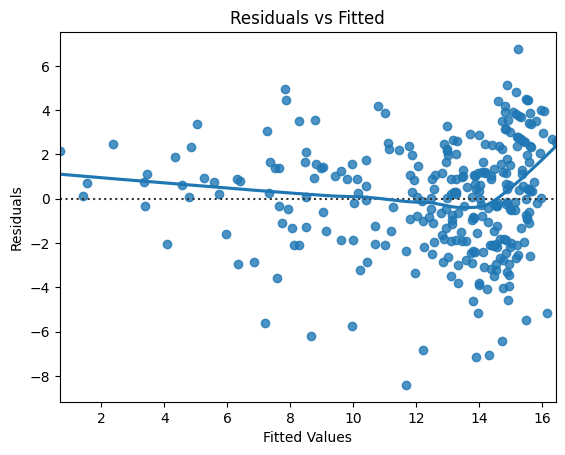

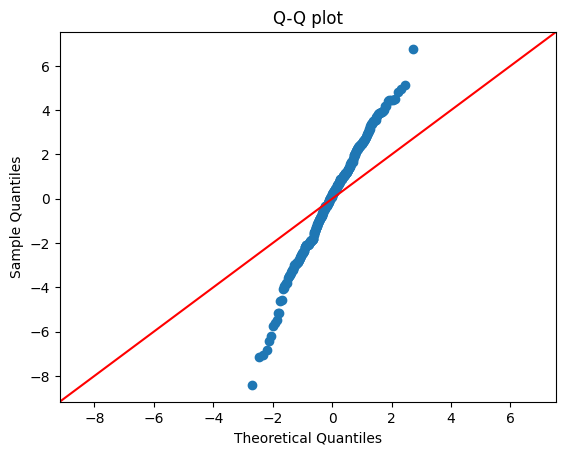

In [124]:
X = model_data[['in_degree_centrality', 'out_degree_centrality', 
                'betweenness_centrality', 'closeness_centrality', 
                'clustering_coefficient']]
y = model_data['avg_ranking']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Adding a constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# Predict and calculate RMSE for train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Residuals plot
residuals = y_train - y_train_pred
sns.residplot(x=y_train_pred, y=residuals, lowess=True)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# Q-Q plot for normality of residuals
sm.qqplot(residuals, line='45')
plt.title('Q-Q plot')
plt.show()


**OLS + Interaction terms**

In [125]:
# Adding interaction terms
interaction_model_data = dmatrix('in_degree_centrality + out_degree_centrality + betweenness_centrality + closeness_centrality + clustering_coefficient + \
                                 in_degree_centrality:out_degree_centrality + in_degree_centrality:betweenness_centrality + \
                                 out_degree_centrality:betweenness_centrality', data=model_data, return_type='dataframe')

model = sm.OLS(y, interaction_model_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            avg_ranking   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     81.45
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           6.77e-76
Time:                        22:45:55   Log-Likelihood:                -847.40
No. Observations:                 367   AIC:                             1713.
Df Residuals:                     358   BIC:                             1748.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

**Decision Tree, Random Forest, Gradient Boosting, Support Vector Regression and Neural Network**

In [126]:
X = model_data[['in_degree_centrality', 'out_degree_centrality', 
                'betweenness_centrality', 'closeness_centrality', 
                'clustering_coefficient']]
y = model_data['avg_ranking']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Models and their RMSEs
models = {
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=1e3, gamma=0.1),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
}

rmse_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rmse_results[name] = rmse

# Display RMSE results
rmse_results_df = pd.DataFrame(list(rmse_results.items()), columns=['Model', 'Test RMSE'])
print(rmse_results_df)

                       Model  Test RMSE
0              Decision Tree   2.745187
1              Random Forest   2.336748
2          Gradient Boosting   2.561084
3  Support Vector Regression   2.721463
4             Neural Network   2.358783


d:\Users\Riccardo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Focus on Random Forest

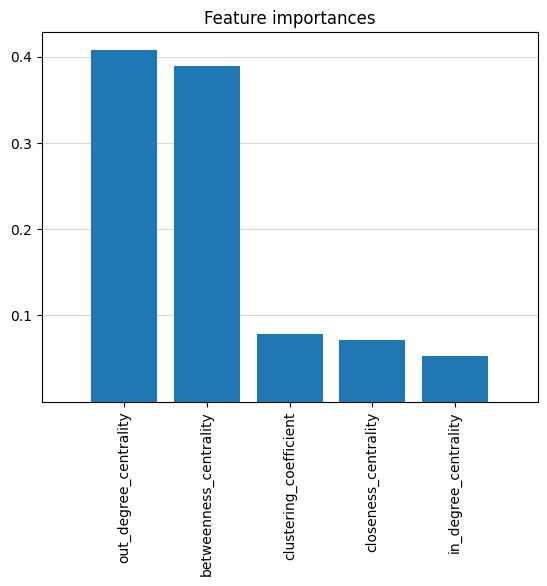

In [127]:
# model_data = model_data.sample(frac = 1)

X = model_data[['in_degree_centrality', 'out_degree_centrality', 
                'betweenness_centrality', 'closeness_centrality', 
                'clustering_coefficient']]
y = model_data['avg_ranking']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Assuming you have a trained model
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42).fit(X, y)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns  # Adjust this based on your dataframe

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center", zorder=3)
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.yticks([.10, .20, .30, .40])    
plt.xlim([-1, X.shape[1]])
plt.grid(which = 'major', axis = 'y', zorder=0, alpha = 0.5)
plt.show()


In [ ]:
# !pip install shap

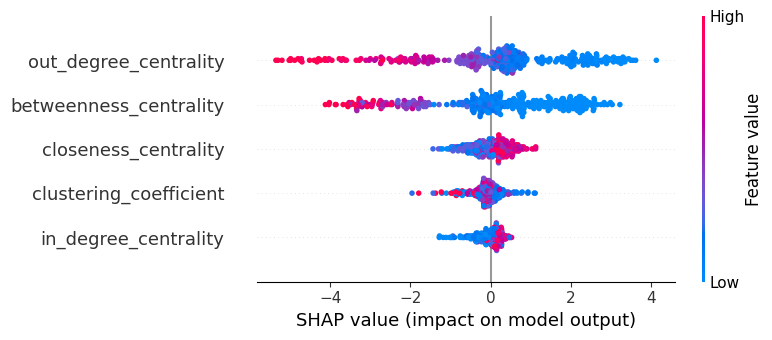

In [131]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, feature_names=feature_names)
